<a href="https://colab.research.google.com/github/OdinViolet/Neuromatch/blob/main/tutorials/W3D4_ReinforcementLearning/student/W3D4_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Learning to Predict

**Week 3, Day 4: Reinforcement Learning**

**By Neuromatch Academy**

**Content creators:** Marcelo G Mattar, Eric DeWitt, Matt Krause, Matthew Sargent, Anoop Kulkarni, Sowmya Parthiban, Feryal Behbahani, Jane Wang

**Content reviewers:** Ella Batty, Byron Galbraith, Michael Waskom, Ezekiel Williams, Mehul Rastogi, Lily Cheng, Roberto Guidotti, Arush Tagade, Kelson Shilling-Scrivo

**Production editors:** Gagana B, Spiros Chavlis

---

# Tutorial objectives

*Estimated timing of tutorial: 50 min*

Reinforcement Learning (RL) is a framework for defining and solving a problem where an agent learns to take actions that maximize reward. The problem setting is as follows: an agent, biological or artificial, observes the current state of the world and selects an action based on that state. Upon executing an action, the agent receives a reward and uses this information to improve its future actions. Reinforcement learning provides formal, optimal descriptions of learning. These descriptions were first derived from studies of animal behavior and then validated when the formal quantities used in the model were observed in the brain in humans and animals.

Reinforcement learning is a broad framework and it has deep connections to many topics covered in NMA. For instance, most of reinforcement learning defines the world as a Markov Decision Problem, which is built on Hidden Dynamics and Optimal Control. More broadly, reinforcement learning can be seen as a framework that allows us to bring in many ideas and formalisms from other areas like economics, psychology, computer science, artificial intelligence, etc. to define algorithms or models that can solve large, complex problems with only a simple reward signal.

In this tutorial, we will model the agent as an observer that learns to predict future rewards. This agent takes no actions and thus cannot influence how much reward it receives. By predicting how much reward follows from each state, the agent can learn to identify the best states of the world -- i.e. the ones that tend to be followed by the most reward.

More specifically, we will learn how to estimate state-value functions in a classical conditioning paradigm using Temporal Difference (TD) learning and examine TD-errors at the presentation of the conditioned and unconditioned stimulus (CS and US) under different CS-US contingencies. These exercises will provide you with an understanding of both how reward prediction errors (RPEs) behave in classical conditioning and what we should expect to see if Dopamine represents a "canonical" model-free RPE.

At the end of this tutorial:
* You will learn to use the standard tapped delay line conditioning model
* You will understand how RPEs move to CS
* You will understand how variability in reward size effects RPEs
* You will understand how differences in US-CS timing effect RPEs

Tutorials 1-4 should take a 3+ hours to complete, though it could take longer if you're completely new to this material and/or if you are interested in studying all of the extra material.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for all videos in this tutorial.
from IPython.display import IFrame
link_id = "2jzdu"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [ ]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W3D4_T1"

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions
from matplotlib import ticker

def plot_value_function(V, ax=None, show=True):
  """Plot V(s), the value function"""
  if not ax:
    fig, ax = plt.subplots()

  ax.stem(V)
  ax.set_ylabel('Value')
  ax.set_xlabel('State')
  ax.set_title("Value function: $V(s)$")

  if show:
    plt.show()


def plot_tde_trace(TDE, ax=None, show=True, skip=400):
  """Plot the TD Error across trials"""
  if not ax:
    fig, ax = plt.subplots()

  index = np.arange(0, TDE.shape[1], skip)
  im = ax.imshow(TDE[:,index])
  positions = ax.get_xticks()
  # Avoid warning when setting string tick labels
  ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
  ax.set_xticklabels([f"{int(skip * x)}" for x in positions])
  ax.set_title('TD-error over learning')
  ax.set_ylabel('State')
  ax.set_xlabel('Iterations')
  ax.figure.colorbar(im)
  if show:
    plt.show()


def learning_summary_plot(V, TDE):
  """Summary plot for Ex1"""
  fig, (ax1, ax2) = plt.subplots(nrows = 2, gridspec_kw={'height_ratios': [1, 2]})

  plot_value_function(V, ax=ax1, show=False)
  plot_tde_trace(TDE, ax=ax2, show=False)
  plt.tight_layout()
  plt.show()

In [4]:
# @title Helper Functions and Classes

def reward_guesser_title_hint(r1, r2):
  """"Provide a mildly obfuscated hint for a demo."""
  if (r1==14 and r2==6) or (r1==6 and r2==14):
    return "Technically correct...(the best kind of correct)"

  if  ~(~(r1+r2) ^ 11) - 1 == (6 | 24): # Don't spoil the fun :-)
    return "Congratulations! You solved it!"

  return "Keep trying...."


class ClassicalConditioning:

    def __init__(self, n_steps, reward_magnitude, reward_time):

        # Task variables
        self.n_steps = n_steps
        self.n_actions = 0
        self.cs_time = int(n_steps/4) - 1

        # Reward variables
        self.reward_state = [0,0]
        self.reward_magnitude = None
        self.reward_probability = None
        self.reward_time = None

        # Time step at which the conditioned stimulus is presented
        self.set_reward(reward_magnitude, reward_time)

        # Create a state dictionary
        self._create_state_dictionary()

    def set_reward(self, reward_magnitude, reward_time):

        """
        Determine reward state and magnitude of reward
        """
        if reward_time >= self.n_steps - self.cs_time:
            self.reward_magnitude = 0

        else:
            self.reward_magnitude = reward_magnitude
            self.reward_state = [1, reward_time]

    def get_outcome(self, current_state):

        """
        Determine next state and reward
        """
        # Update state
        if current_state < self.n_steps - 1:
            next_state = current_state + 1
        else:
            next_state = 0

        # Check for reward
        if self.reward_state == self.state_dict[current_state]:
            reward = self.reward_magnitude
        else:
            reward = 0

        return next_state, reward

    def _create_state_dictionary(self):

        """
        This dictionary maps number of time steps/ state identities
        in each episode to some useful state attributes:

        state      - 0 1 2 3 4 5 (cs) 6 7 8 9 10 11 12 ...
        is_delay   - 0 0 0 0 0 0 (cs) 1 1 1 1  1  1  1 ...
        t_in_delay - 0 0 0 0 0 0 (cs) 1 2 3 4  5  6  7 ...
        """
        d = 0

        self.state_dict = {}
        for s in range(self.n_steps):
            if s <= self.cs_time:
                self.state_dict[s] = [0,0]
            else:
                d += 1 # Time in delay
                self.state_dict[s] = [1,d]


class MultiRewardCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that one randomly selected reward,
    magnitude, from a list, is delivered of a single fixed reward."""
  def __init__(self, n_steps, reward_magnitudes, reward_time=None):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: LIST of possible reward magnitudes.
        - reward_time: Single fixed reward time
      Uses numpy global random state.
      """
    super().__init__(n_steps, 1, reward_time)
    self.reward_magnitudes = reward_magnitudes

  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward=np.random.choice(self.reward_magnitudes)
    return next_state, reward


class ProbabilisticCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that rewards are stochastically omitted."""
  def __init__(self, n_steps, reward_magnitude, reward_time=None, p_reward=0.75):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: Reward magnitudes.
        - reward_time: Single fixed reward time.
        - p_reward: probability that reward is actually delivered in rewarding state
      Uses numpy global random state.
      """
    super().__init__(n_steps, reward_magnitude, reward_time)
    self.p_reward = p_reward

  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward*= int(np.random.uniform(size=1)[0] < self.p_reward)
    return next_state, reward

---
# Section 1: Temporal difference learning

In [ ]:
# @title Video 1: Introduction
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'YoNbc9M92YY'), ('Bilibili', 'BV13f4y1d7om')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Introduction_Video")

__Environment:__

- The agent experiences the environment in episodes (also known as trials).
- Episodes terminate by transitioning to the inter-trial-interval (ITI) state and they are initiated from the ITI state as well. We clamp the value of the terminal/ITI states to zero.
- The classical conditioning environment is composed of a sequence of states that the agent deterministically transitions through. Starting at State 0, the agent moves to State 1 in the first step, from State 1 to State 2 in the second, and so on.  These states represent time in what is called "tapped delay line" representation
- Within each episode, the agent is presented with a CS (cue) and US (reward).
- The CS (cue) is presented at the end of the first quarter the trial. The US (reward) is delivered shortly afterwards. The interval between the CS and US is specified by `reward_time`.
- The agent's goal is to learn to predict expected rewards from each state in the trial.

<br>

**General concepts**

Reference: McClelland, J. L., Rumelhart, D. E. (1989). Explorations in parallel distributed processing: A handbook of models, programs, and exercises. Chapter 9, MIT press. url: [web.stanford.edu/group/pdplab/pdphandbook/handbookch10.html](https://web.stanford.edu/group/pdplab/pdphandbook/handbookch10.html)

<br>

* Return $G_{t}$: future cumulative reward at time $t$:
\begin{equation}
G_{t} = \sum \limits_{k = 0}^{\infty} \gamma^{k} r_{t+k+1}
\end{equation}
where $r_{t}$ is the amount of reward received at time $t$, and $\gamma \in [0, 1]$ is a discount factor that specifies the relevance in the present of future rewards.
Note that the return $G_{t}$ can be written in a recursive form:
\begin{equation}
G_{t} = r_{t+1} + \gamma G_{t+1}
\end{equation}

* State $s$ describes the current state or situation, typically obtained from observations that the agent receives from the environment.

* Policy $\pi$ is a specification of how the agent acts. $\pi(a|s)$ gives the probability of taking action $a$ when in state $s$.

* The value function $V_{\pi}(s_t=s)$ is defined as the expected return starting with state $s$ and successively following policy $\pi$. Roughly speaking, the value function estimates "how good" it is to be in state $s$ when following policy $\pi$.
\begin{align}
V_{\pi}(s_t=s) &= \mathbb{E} [ G_{t}\; | \; s_t=s, a_{t:\infty}\sim\pi] \\
& = \mathbb{E} [ r_{t+1} + \gamma G_{t+1}\; | \; s_t=s, a_{t:\infty}\sim\pi]
\end{align}

* Combining the above, we have:
\begin{align}
V_{\pi}(s_t=s) &= \mathbb{E} [ r_{t+1} + \gamma V_{\pi}(s_{t+1})\; | \; s_t=s, a_{t:\infty}\sim\pi] \\
&= \sum_a \pi(a|s) \sum_{r, s'}p(s', r)(r + V_{\pi}(s_{t+1}=s'))
\end{align}

<br>

**Temporal difference (TD) learning**

* With a [Markovian assumption](https://en.wikipedia.org/wiki/Markov_property), we can use $V(s_{t+1})$ as a proxy for the true value of the return $G_{t+1}$. Thus, we obtain a generalized equation to calculate the TD-error:
\begin{align}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{align}

* The TD-error measures the discrepancy between the values at time $t$ and $t+1$. Once the TD-error is calculated, we can perform a "value update" to to reduce the value discrepancy:

\begin{align}
V(s_{t}) \leftarrow V(s_{t}) + \alpha \delta_{t}
\end{align}

* The speed by which the discrepancy is reduced is specified by a constant (aka hyperparameter) $\alpha$, called learning rate.

<br>

**Definitions (tl;dr):**

* Return:
\begin{equation}
G_{t} = \sum \limits_{k = 0}^{\infty} \gamma^{k} r_{t+k+1} = r_{t+1} + \gamma G_{t+1}
\end{equation}

* TD-error:
\begin{equation}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{equation}

* Value updates:
\begin{equation}
V(s_{t}) \leftarrow V(s_{t}) + \alpha \delta_{t}
\end{equation}

## Coding Exercise 1: TD-learning with guaranteed rewards

In this exercise, you will implement TD-learning to estimate the state-value function in the classical conditioning paradigm. Rewards have fixed magnitude and are delivered at a fixed delay after the conditioned stimulus, CS. You should save the TD-errors over learning (i.e., over trials) so we can visualize them afterwards.

In order to simulate the effect of the CS, you should update $V(s_{t})$ only during the delay period after CS. This period is indicated by the boolean variable `is_delay`. This can be implemented by multiplying the expression for updating the value function by `is_delay`.

Use the provided code to estimate the value function. We will use helper class `ClassicalConditioning`.

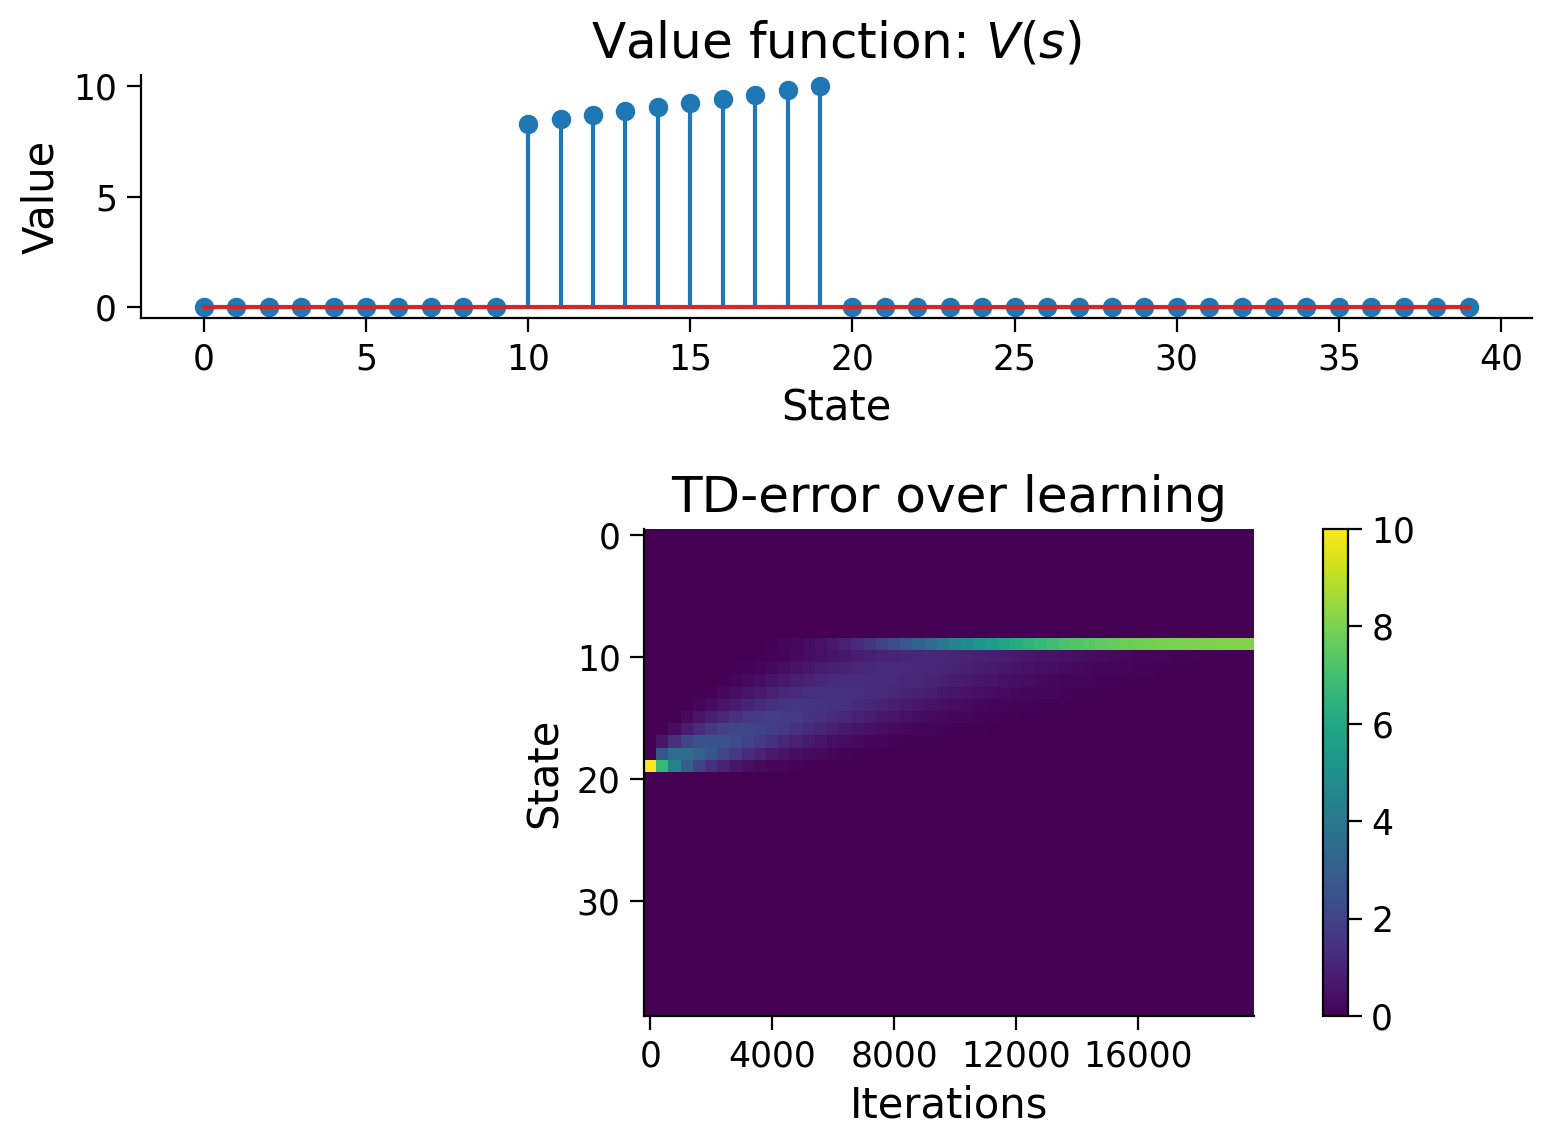

In [6]:
def td_learner(env, n_trials, gamma=0.98, alpha=0.001):
  """ Temporal Difference learning

  Args:
    env (object): the environment to be learned
    n_trials (int): the number of trials to run
    gamma (float): temporal discount factor
    alpha (float): learning rate

  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """
  V = np.zeros(env.n_steps) # Array to store values over states (time)
  TDE = np.zeros((env.n_steps, n_trials)) # Array to store TD errors

  for n in range(n_trials):

    state = 0 # Initial state

    for t in range(env.n_steps):

      # Get next state and next reward
      next_state, reward = env.get_outcome(state)

      # Is the current state in the delay period (after CS)?
      is_delay = env.state_dict[state][0]

      ########################################################################
      ## TODO for students: implement TD error and value function update
      # Fill out function and remove
      # raise NotImplementedError("Student exercise: implement TD error and value function update")
      #################################################################################
      # Write an expression to compute the TD-error
      TDE[state, n] = (reward + gamma * V[next_state] - V[state])

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state

  return V, TDE


# Initialize classical conditioning class
env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)

# Perform temporal difference learning
V, TDE = td_learner(env, n_trials=20000)

# Visualize
learning_summary_plot(V, TDE)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D4_ReinforcementLearning/solutions/W3D4_Tutorial1_Solution_adeb004b.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D4_ReinforcementLearning/static/W3D4_Tutorial1_Solution_adeb004b_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_TD_learning_Exercise")

## Interactive Demo 1.1: US to CS Transfer

During classical conditioning, the subject's behavioral response (e.g., salivating) transfers from the unconditioned stimulus (US; like the smell of tasty food) to the conditioned stimulus (CS; like Pavlov ringing his bell) that predicts it. Reward prediction errors play an important role in this process by adjusting the value of states according to their expected, discounted return.

Recall that TD-errors are given by:

\begin{equation}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{equation}

The delay period has zero reward, so throughout the learning phase, the TD-errors result from inconsistencies between $V(s_{t+1})$ and $V(s_{t})$ (note that the discount factor is set to zero in this example). The TD-errors for a given time point diminish once $V(s_{t})$ approaches $V(s_{t+1})$, but that causes the TD-error for the preceding time point to increase. Thus, throughout learning, the TD-errors will tend to move backwards in time.

Use the widget below to examine how reward prediction errors change over time.

Before training (orange line), only the reward state has high reward prediction error (blue line). As training progresses (slider), the reward prediction errors shift to the conditioned stimulus, where they end up when the trial is complete (green line).

Dopamine neurons, which are thought to carry reward prediction errors _in vivo_, show exactly the same behavior!

In [7]:
# @markdown Make sure you execute this cell to enable the widget!

n_trials = 20000

@widgets.interact
def plot_tde_by_trial(trial = widgets.IntSlider(value=5000, min=0, max=n_trials-1 , step=1, description="Trial #")):
  if 'TDE' not in globals():
    print("Complete Exercise 1 to enable this interactive demo!")
  else:

    fig, ax = plt.subplots()
    ax.axhline(0, color='k') # Use this + basefmt=' ' to keep the legend clean.
    ax.stem(TDE[:, 0], linefmt='C1-', markerfmt='C1d', basefmt=' ',
            label="Before Learning (Trial 0)")
    ax.stem(TDE[:, -1], linefmt='C2-', markerfmt='C2s', basefmt=' ',
            label=r"After Learning (Trial $\infty$)")
    ax.stem(TDE[:, trial], linefmt='C0-', markerfmt='C0o', basefmt=' ',
            label=f"Trial {trial}")

    ax.set_xlabel("State in trial")
    ax.set_ylabel("TD Error")
    ax.set_title("Temporal Difference Error by Trial")
    ax.legend()
    plt.show()

interactive(children=(IntSlider(value=5000, description='Trial #', max=19999), Output()), _dom_classes=('widge…

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_US_to_CS_transfer_Interactive_Demo")

## Interactive Demo 1.2: Learning Rates and Discount Factors

Our TD-learning agent has two parameters that control how it learns: $\alpha$, the learning rate, and $\gamma$, the discount factor. In Exercise 1, we set these parameters to $\alpha=0.001$ and $\gamma=0.98$ for you. Here, you'll investigate how changing these parameters alters the model that TD-learning learns.

Before enabling the interactive demo below, take a moment to think about the functions of these two parameters. $\alpha$ controls the size of the Value function updates produced by each TD-error. In our simple, deterministic world, will this affect the final model we learn? Is a larger $\alpha$ necessarily better in more complex, realistic environments?

The discount rate $\gamma$ applies an exponentially-decaying weight to returns occurring in the future, rather than the present timestep. How does this affect the model we learn? What happens when $\gamma=0$ or $\gamma \geq 1$?

Use the widget to test your hypotheses.




In [8]:
# @markdown Make sure you execute this cell to enable the widget!

@widgets.interact
def plot_summary_alpha_gamma(alpha=widgets.FloatSlider(value=0.0001, min=0.0001,
                                                       max=0.1, step=0.0001,
                                                       readout_format='.4f',
                                                       description="alpha"),
                             gamma=widgets.FloatSlider(value=0.980, min=0,
                                                       max=1.1, step=0.010,\
                                                       description="γ")):
  env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)
  try:
    V_params, TDE_params = td_learner(env, n_trials=20000, gamma=gamma,
                                      alpha=alpha)
  except NotImplementedError:
    print("Finish Exercise 1 to enable this interactive demo")

  learning_summary_plot(V_params,TDE_params)

interactive(children=(FloatSlider(value=0.0001, description='alpha', max=0.1, min=0.0001, readout_format='.4f'…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D4_ReinforcementLearning/solutions/W3D4_Tutorial1_Solution_80376f94.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Learning_rates_and_discount_factors_Interactive_Demo_and_Discussion")

---
# Section 2: TD-learning with varying reward magnitudes

*Estimated timing to here from start of tutorial: 30 min*

In the previous exercise, the environment was as simple as possible. On every trial, the CS predicted the same reward, at the same time, with 100% certainty. In the next few exercises, we will make the environment more progressively more complicated and examine the TD-learner's behavior.


## Interactive Demo 2: Match the Value Functions

First, will replace the environment with one that dispenses one of several rewards, chosen at random. Shown below is the final value function $V$ for a TD learner that was trained in an environment where the CS predicted a reward of 6 or 14 units; both rewards were equally likely).

Can you find another pair of rewards that cause the agent to learn the same value function? Assume each reward will be dispensed 50% of the time.

Hints:
* Carefully consider the definition of the value function $V$. This can be solved analytically.
* There is no need to change $\alpha$ or $\gamma$.
* Due to the randomness, there may be a small amount of variation.

In [9]:
# @markdown Make sure you execute this cell to enable the widget!

# @markdown Please allow some time for the new figure to load

n_trials = 20000
np.random.seed(2020)
rng_state = np.random.get_state()
env = MultiRewardCC(40, [6, 14], reward_time=10)
V_multi, TDE_multi = td_learner(env, n_trials, gamma=0.98, alpha=0.001)

@widgets.interact
def reward_guesser_interaction(r1 = widgets.IntText(value=0, min=0, max=50, description="Reward 1"),
                               r2 = widgets.IntText(value=0, min=0, max=50, description="Reward 2")):
  try:
    env2 = MultiRewardCC(40, [r1, r2], reward_time=10)
    V_guess, _ = td_learner(env2, n_trials, gamma=0.98, alpha=0.001)
    fig, ax = plt.subplots()
    m, l, _ = ax.stem(V_multi, linefmt='y-', markerfmt='yo',
                      basefmt=' ', label="Target")
    m.set_markersize(15)
    m.set_markerfacecolor('none')
    l.set_linewidth(4)
    m, _, _ = ax.stem(V_guess, linefmt='r', markerfmt='rx',
                      basefmt=' ', label="Guess")
    m.set_markersize(15)

    ax.set_xlabel("State")
    ax.set_ylabel("Value")
    ax.set_title(f"Guess V(s)\n{reward_guesser_title_hint(r1, r2)}")
    ax.legend()
    plt.show()
  except NotImplementedError:
    print("Please finish Exercise 1 first!")

interactive(children=(IntText(value=0, description='Reward 1'), IntText(value=0, description='Reward 2'), Outp…

## Think! 2: Examining the TD Error

Run the cell below to plot the TD errors from our multi-reward environment. A new feature appears in this plot? What is it? Why does it happen?

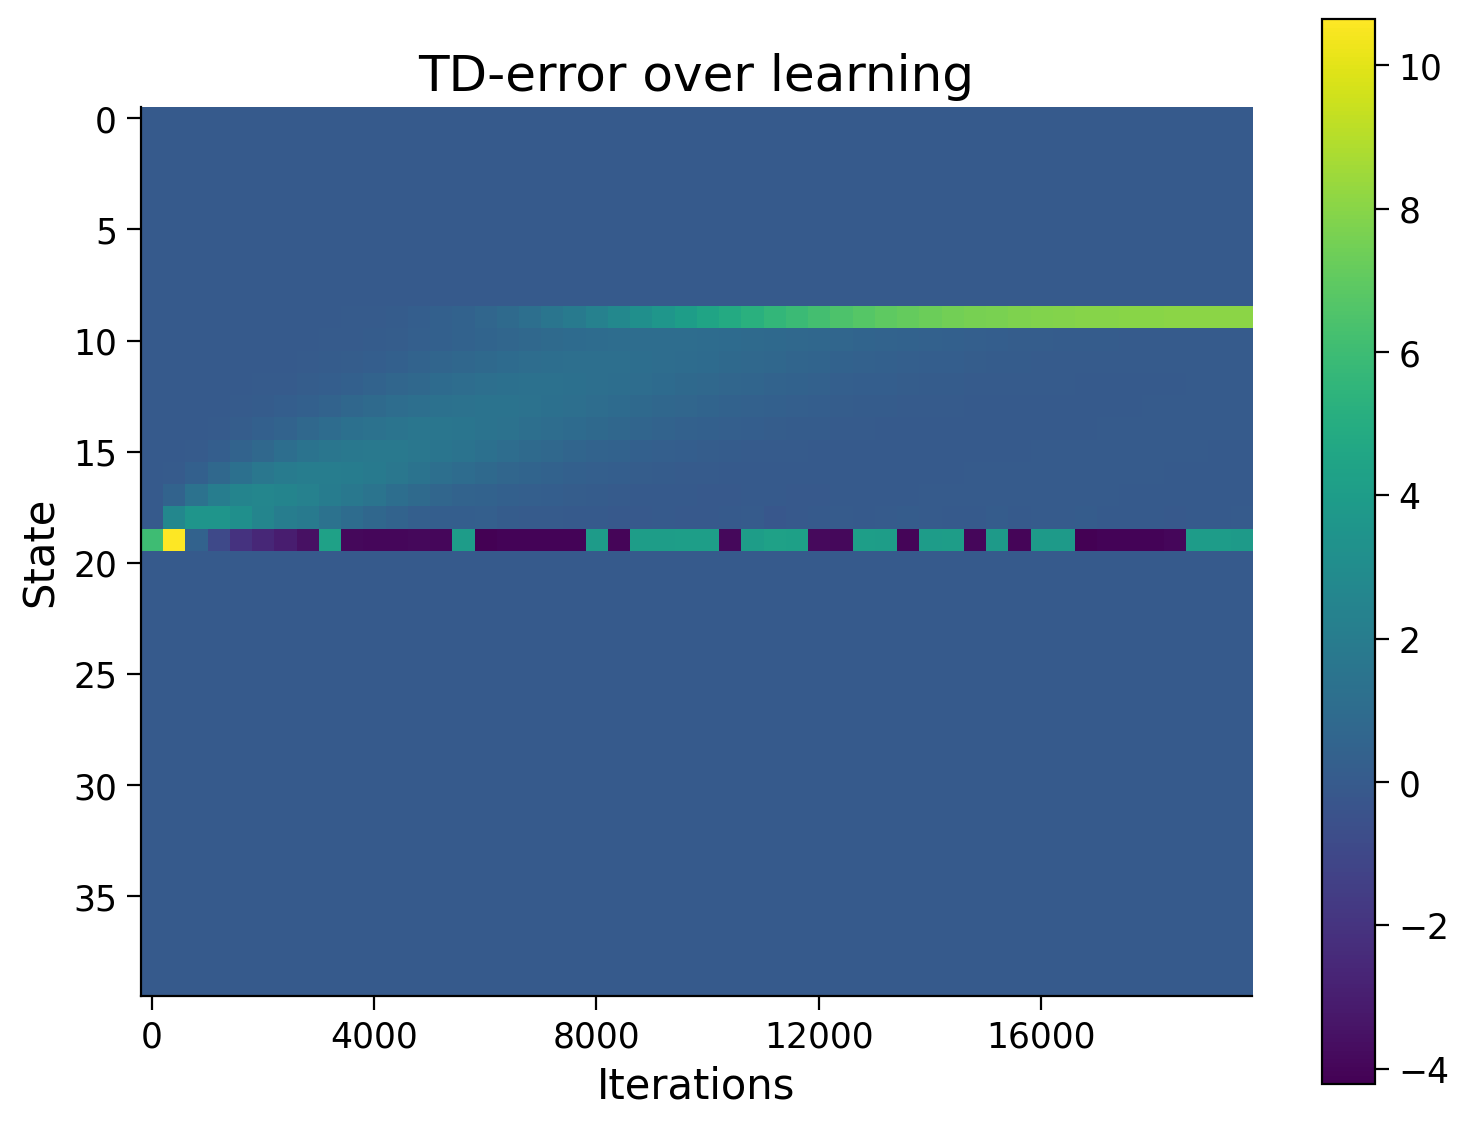

In [10]:
# @markdown Execute the cell
plot_tde_trace(TDE_multi)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D4_ReinforcementLearning/solutions/W3D4_Tutorial1_Solution_9fd42e7d.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Examining_the_TD_Error_Discussion")

---
# Section 3: TD-learning with probabilistic rewards
*Estimated timing to here from start of tutorial: 40 min*

## Think! 3: Probabilistic rewards


In this environment, we'll return to delivering a single reward of ten units. However, it will be delivered intermittently: on 20 percent of trials, the CS will be shown but the agent will not receive the usual reward; the remaining 80% will proceed as usual.

Run the cell below to simulate. Recall that earlier in the notebook, we saw that changing $\alpha$ had little effect on learning in a deterministic environment. In the simulation below, $\alpha$ is set to 1. What happens when the learning rate is set to such a large value in a probability reward setting? Does it seem like it will _ever_ converge?

With a high learning rate, the value function tracks each observed reward, changing quickly whenever there is a reward prediction error. In a probabilistic scenario case, this behavior results in the value function changing too quickly and never stabilizing (converging). Using a low learning rate can stabilize the value function by smoothing out any variation in the reward signal, leading the value function to converge to the average reward over time. However, using a low learning rate can result in slow learning.

To get the best of all worlds, it is often useful to use a high learning rate early on (producing fast learning), and to reduce the learning rate gradually throughout learning (so that the value function converges to the average reward). This is sometimes called "learning rate schedule".

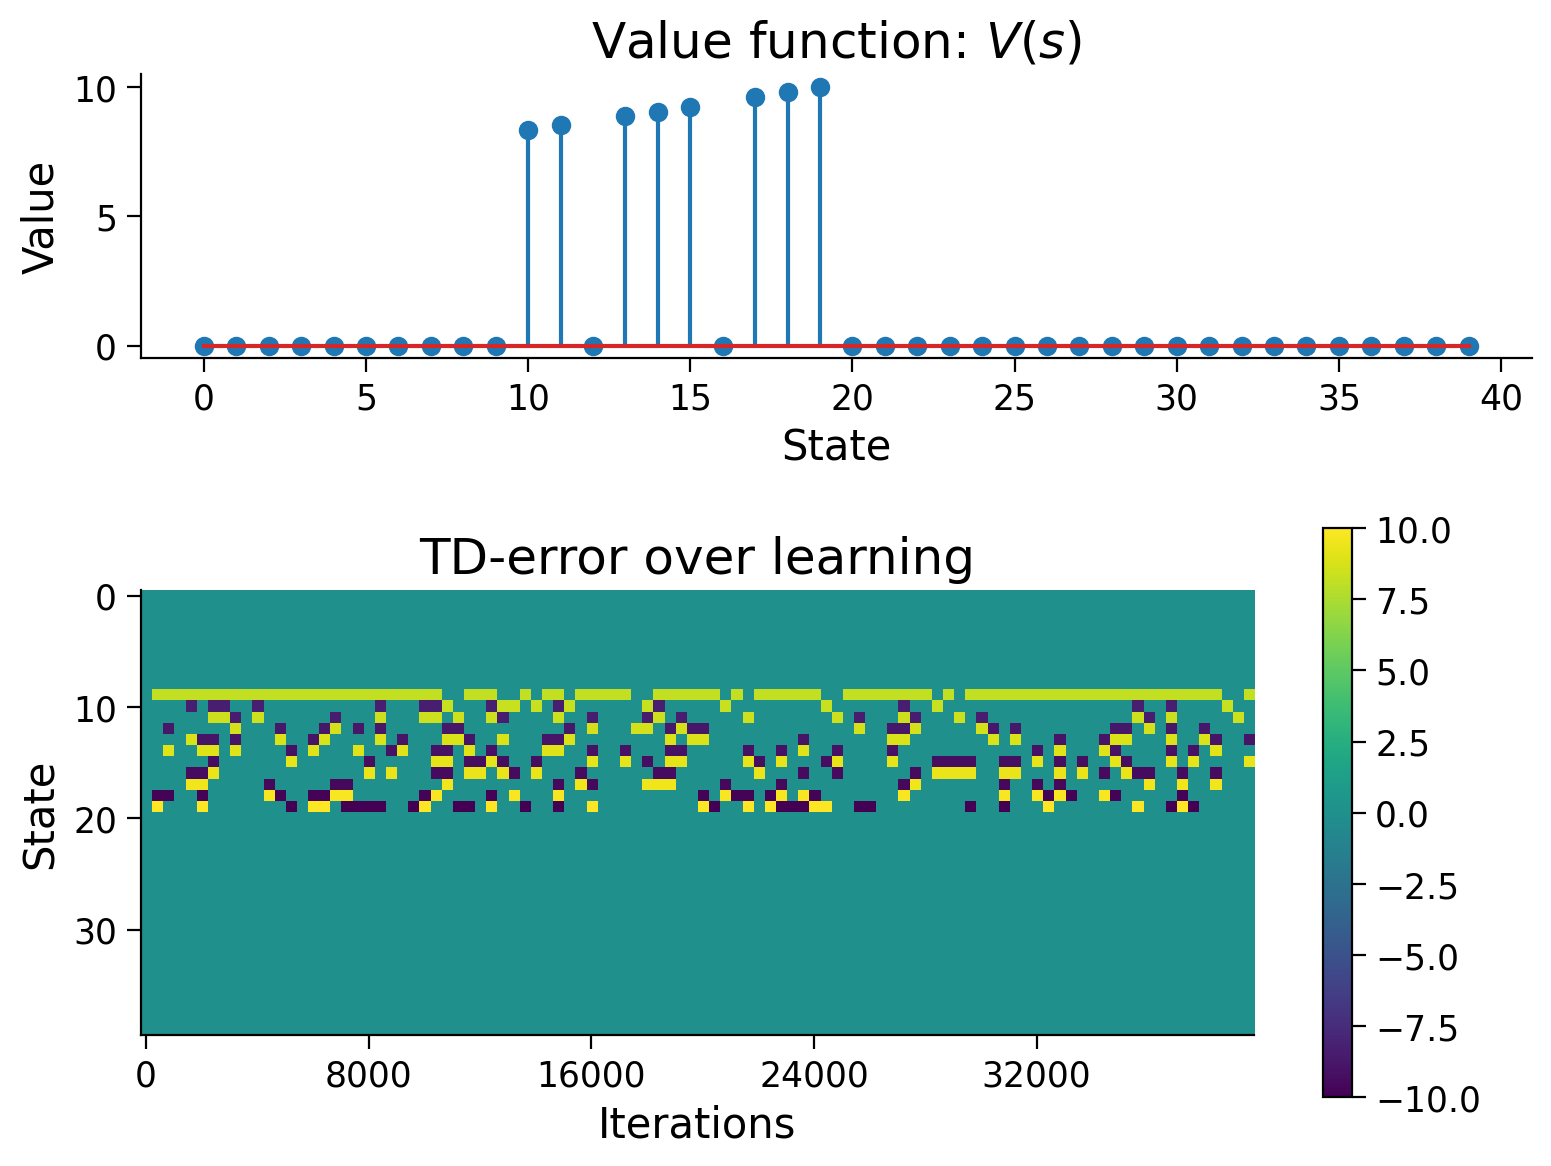

In [11]:
# @markdown Execute this cell to visualize the value function and TD-errors when `alpha=1`
np.random.set_state(rng_state)  # Resynchronize everyone's notebooks
n_trials = 20000
try:
  env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10,
                        p_reward=0.8)
  V_stochastic, TDE_stochastic = td_learner(env, n_trials*2, alpha=1)
  learning_summary_plot(V_stochastic, TDE_stochastic)
except NotImplementedError:
  print("Please finish Exercise 1 first")

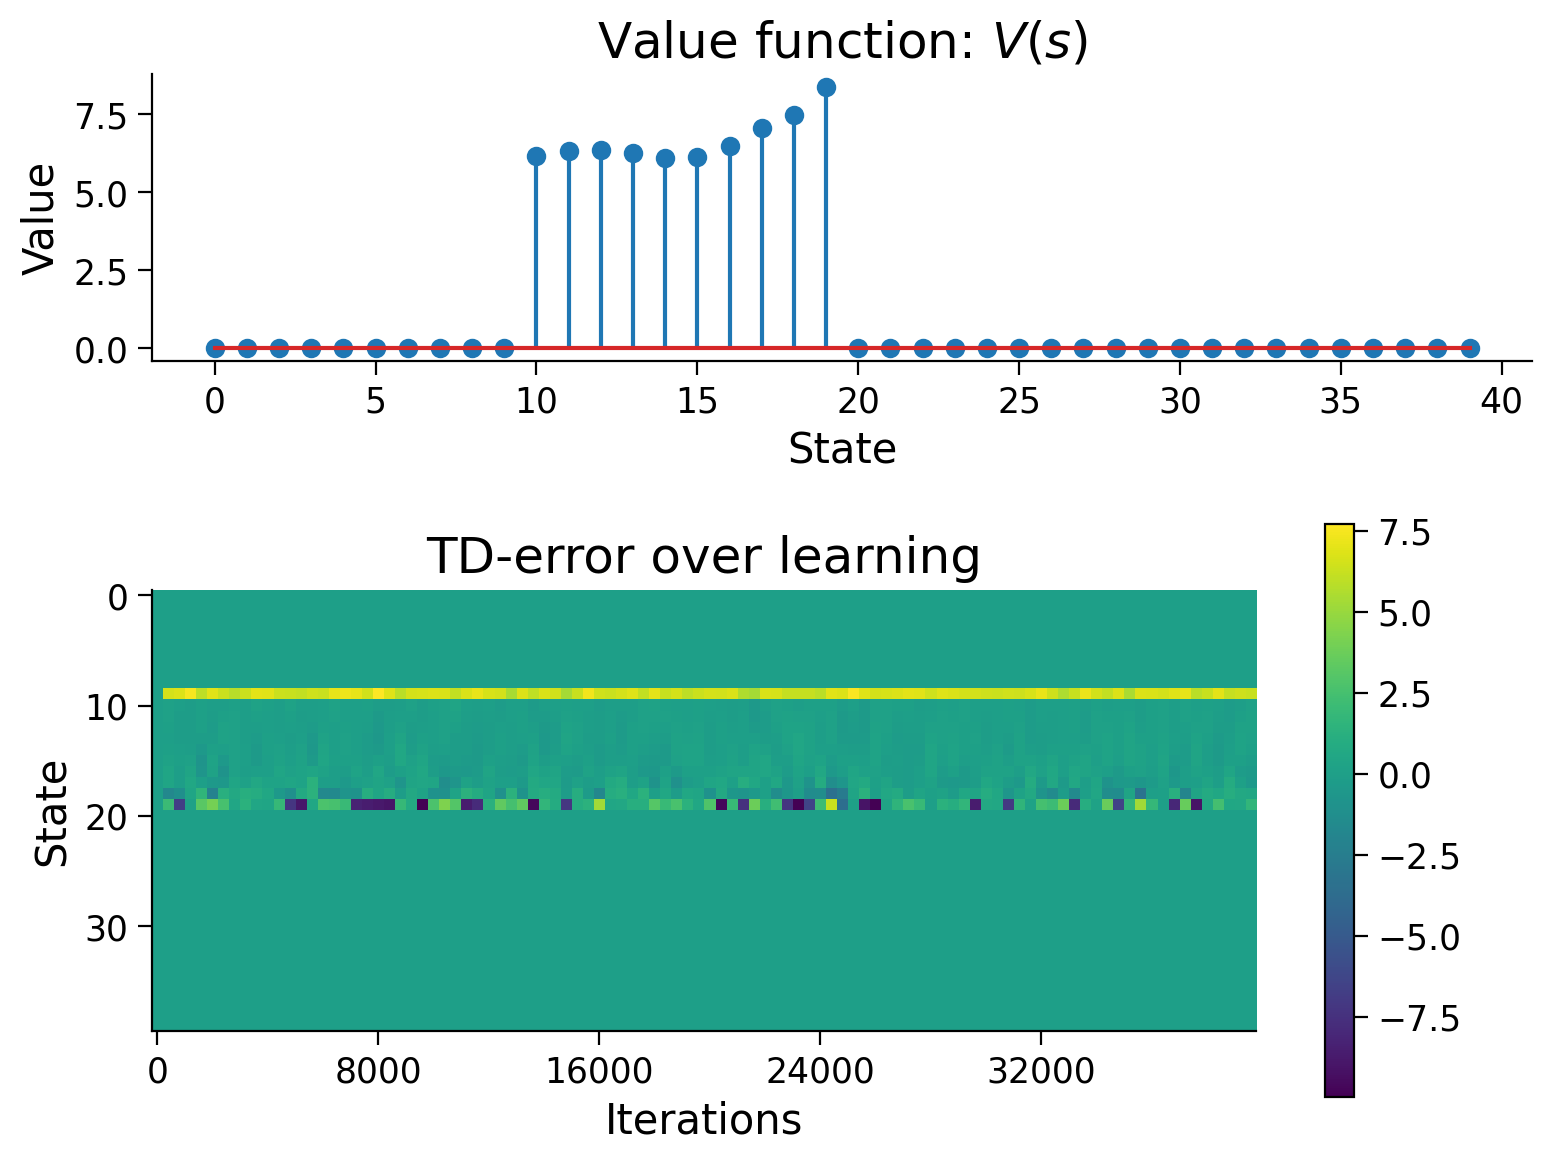

In [12]:
# @markdown Execute this cell to visualize the value function and TD-errors when `alpha=0.2`
np.random.set_state(rng_state)  # Resynchronize everyone's notebooks
n_trials = 20000
try:
  env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10,
                        p_reward=0.8)
  V_stochastic, TDE_stochastic = td_learner(env, n_trials*2, alpha=.2)
  learning_summary_plot(V_stochastic, TDE_stochastic)
except NotImplementedError:
  print("Please finish Exercise 1 first")

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D4_ReinforcementLearning/solutions/W3D4_Tutorial1_Solution_6e708fa1.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Probabilistic_rewards_Discussion")

---
# Summary

*Estimated timing of tutorial: 50 min*

In this notebook, we have developed a simple TD Learner and examined how its state representations and reward prediction errors evolve during training. By manipulating its environment and parameters ($\alpha$, $\gamma$), you developed an intuition for how it behaves.

This simple model closely resembles the behavior of subjects undergoing classical conditioning tasks and the dopamine neurons that may underlie that behavior. You may have implemented TD-reset or used the model to recreate a common experimental error. The update rule used here has been extensively studied for [more than 70 years](https://www.pnas.org/content/108/Supplement_3/15647) as a possible explanation for artificial and biological learning.

However, you may have noticed that something is missing from this notebook. We carefully calculated the value of each state, but did not use it to actually do anything. Using values to plan _**Actions**_ is coming up next!

---
# Bonus

## Bonus Think! 1: Removing the CS

In Coding Exercise 1, you (should have) included a term that depends on the conditioned stimulus. Remove it and see what happens. Do you understand why?
This phenomena often fools people attempting to train animals--beware!

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D4_ReinforcementLearning/solutions/W3D4_Tutorial1_Solution_f4fa447c.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Removing_the_CS_Bonus_Discussion")